['step=', '1', 'N=', '25', 'L=', '28.050000000000004']
['step=', '1001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '2001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '3001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '4001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '5001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '6001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '7001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '8001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '9001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '10001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '11001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '12001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '13001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '14001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '15001', 'N=', '25', 'L=', '28.050000000000004']
['step=', '16001', 'N=', '25', 'L=', '28.050000000000004']
['step=', 

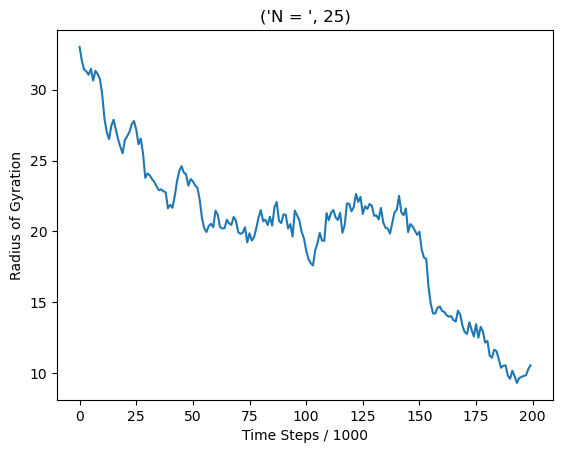

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

#################################################################
def Polymer_MD_Python():
    # initialize parameters
    N = 25 #no. of particles        # 25, 10, 5
    T = 0.05 #temperature
    dt = 0.0005 #integration time step
    steps = 200000 #time steps

    epsilon_LJ = 0    
    cutff_LJ = 2.5
    spring_coeff = 5     # k
    min_sep = 1.122    # r_o

    L = min_sep*N
    print_interval = 1000
####################################################################
    #initialize x coordinates
    x = initial_configuration(min_sep, N)
    pairs = []
#####################################################################
    #main loop
    
    #array to store radii
    radii = [0] * 200
    k = 0
    
    for step_i in range(0, steps): #molecular dynamics loop
        x, pairs = steepest_descent(N, x, dt, cutff_LJ, epsilon_LJ, min_sep, spring_coeff, T)
        if (np.mod(step_i-1,print_interval) == 0):  #print every 1000 steps
            mytitle = ["step=",str(step_i), "N=", str(N), "L=", str(L)]
            print(mytitle)
            # visualize_particles(N, x, L, pairs, mytitle)
            rad = Rg(N, x, pairs)     # return radius of gyration
            radii[k] = rad
            k = k +1
            
    time_array = np.array(range(0,200))
    
    title = ("N = ", N)
    plt.plot(time_array, radii)
    plt.title(title)
    plt.ylabel("Radius of Gyration")
    plt.xlabel("Time Steps / 1000")
    plt.show()



# Initial coordinates of every amino acid.
def initial_configuration(initial_min_sep, N):
    x = np.zeros((N, 2))
    for i in range(0,N):
        x[i][0] = initial_min_sep*i - (initial_min_sep*N/2)
    return x


def steepest_descent(N,x,dt, cutoff_LJ,epsilon_LJ,min_sep,spring_coeff,T):
    F_particles,_,pairs = forces(N,x,cutoff_LJ,epsilon_LJ,min_sep,spring_coeff)
    F = F_particles
    x = x + (dt * F) + np.dot(T, (np.random.rand(x.shape[0], x.shape[1]) - 0.5))
    return x, pairs


def all_interactions(N,x,cutoff): #obtain interacting pairs
    ip =0
    connector = []
    pair = []
    for i in range(0, N-1):
        for j in range(i+1, N):
            distance = x[j,:]-x[i,:]  # distance : (1x2)
            if np.linalg.norm(distance) < cutoff:
                ip = ip + 1
                pair.append([i,j])
                connector.append([distance])
    return ip, pair, connector

#Obtain interacting pairs
def spring_interactions(N,x):
    ip = 0
    connector = []
    pair = []
    for i in range(0, N-1):
        j = i+1
        distance = x[j,:]-x[i,:]
        ip += 1
        pair.append([i,j])
        connector.append([distance])
    return ip, pair, connector

def forces(N,x,cutoff_LJ,epsilon_LJ,min_sep,spring_coeff):
    F = np.zeros((N,2))
    P = np.zeros((N,2))
    # LJ Forces
    no, pair, connector = all_interactions(N,x,cutoff_LJ) #interacting pairs
    for i in range(0, no):
        FORCE = force_LJ(connector[i], epsilon_LJ)
        F[pair[i][0]] = F[pair[i][0]]-FORCE
        F[pair[i][1]]=F[pair[i][1]]+FORCE #action = reaction
        P[pair[i][0]]=P[pair[i] [0]]+(np.sum(FORCE* connector[i], axis=0))
        P[pair[i][1]]=P[pair[i][1]]+(np.sum(FORCE* connector[i], axis=0))

    #Spring Forces
    no, pair, connector = spring_interactions(N, x) #interacting pairs
    for i in range(0,no):
        FORCE = force_springs(connector[i], spring_coeff, min_sep)
        F[pair[i][0]]=F[pair[i][0]]-FORCE
        F[pair[i][1]]=F[pair[i][1]]+FORCE # action = reaction;
        P[pair[i][0]]=P[pair[i][0]]+(np.sum(FORCE* connector[i], axis=0))
        P[pair[i][1]]=P[pair[i][1]]+(np.sum(FORCE* connector[i], axis=0))
    return F, P, pair

def force_springs(r_vector,spring_coeff_array,min_sep):
    r2 = np.sum(np.square(r_vector), axis = 1)
    r = np.sqrt(r2)
    curr_force = np.zeros((len(r2),2))
    val_1 = np.multiply(np.subtract(r,min_sep), (np.divide(r_vector[0][0], r)), out=None)
    val_2 = np.multiply(np.subtract(r,min_sep), (np.divide(r_vector[0][1], r)), out=None)
    curr_force[0][0] = np.multiply(np.transpose(-spring_coeff_array), val_1 )
    curr_force[0][1] = np.multiply(np.transpose(-spring_coeff_array), val_2)
    return curr_force

def force_LJ(r_vector, epsilon_LJ):
    r = np.linalg.norm(r_vector)
    force_LJ = 24*epsilon_LJ*np.dot((np.dot(2,r**(-14))-r**(-8)),r_vector)
    return force_LJ

def visualize_particles(N, x, L, pairs, mytitle):
    X = [i[0] for i in x]
    Y = [i[1] for i in x]
    colors = (0,0,0)
    plt.ylim(top=10,bottom=-10)
    plt.xlim([-10,10])
    plt.scatter(X, Y, c=colors, alpha=0.5)
    plt.title(mytitle)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()
    return




### 

# x is a matrix containing coordinate vectors for each particle (1 through N)

def Rg(N, x, pairs):
    radius = 0
    for i in range(0,N):
        ri = np.array(x[i][0], x[i][1])
        for j in range(0,N):
            rj = np.array(x[j][1], x[j][0])  # inverse vector
            radius = radius + (1/(2*(N**2))) * (ri + rj)**2
            
    return radius


Polymer_MD_Python()


In [33]:

steps = 200000
print_interval = 1000
num = (steps/print_interval)
radii = np.zeros(200, dtype = int)
print (radii)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
